# Yield Curve Construction

Using CME Term SOFR, we will construct the short end of the yield curve from scratch. This will consist of the 1-month, 3-month, 6-month and 12-month term SOFR. In addition, the spot SOFR will be used as well. We will stick to the ACT/360 convention for calculations.

There are many choice for interpolation as well as how to interpolate the values. Our choice would be simple linear interpolation on the Effective annual rate (EAR), which is also known as Yield. Other linear interpolation can be on the discount factors/zero coupon bonds or the logarithm of rates. The formula is stated below:

### Linear Interpolation Formula on EAR

Given two known points $(t_0, r_0)$ and $(t_1, r_1)$, the interpolated rate $r$ at a point $t$ where $t_0 \leq t \leq t_1 $ is:

$$
r(t) = \frac{t - t_0}{t_1 - t_0} \cdot (r_1) + \frac{t_1 - t}{t_1 - t_0} \cdot (r_0)
$$

### 1. Create dataframe
- We will create a dataframe that consist of adjusted start and end dates as well as payment dates.
- For Term SOFR, we will add 2 business days from the reference date as the start date. The payment date would be the same as the end adjusted date.
- SOFR is an overnight rate, and its value is typically published on the following business day. To ensure that market participants have a reliable and verified rate to reference, a lag is necessary.


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import Day, BDay
from scipy.optimize import brentq
import bisect
from scipy import interpolate
import matplotlib.pyplot as plt

ref_date = dt.datetime(2024,5,14)
spot_SOFR = 0.0531

#Use ACT/360
DIY = 360

#In Months
key_1 = ['1M','3M','6M','12M']
val_1 = [5.31964, 5.3267 ,5.29355, 5.15822]

CME_Term_SOFR = dict(zip(key_1,np.array(val_1)/100))

def time_convert(dict_):
    """"Convert to months"""
    new_dict = dict()
    for k,v in dict_.items():
        if k[-1] == 'M':
            new_dict[int(k[:-1])] = v
        if k[-1] == 'Y':
            new_dict[int(k[:-1])*12] = v
    return new_dict

def is_business_day(date):
    bdays = BDay()
    print(date + 0*bdays)
    return date == date + 0*bdays

def create_df(ref_date, spot, CME_Term_SOFR):
    len_1 = len(CME_Term_SOFR)
    
    dict_1 = time_convert(CME_Term_SOFR)
    dict_1_k, dict_1_v = list(dict_1.keys()), list(dict_1.values())
    
    data = { 'Months': [0] + dict_1_k,
            'Quotes': [spot] + dict_1_v}
    
    df = pd.DataFrame(data)
    df.loc[0,'Start_Adj'] = ref_date
    df.loc[1:,'Start_Adj'] = ref_date + 2*BDay()
    df['End_Unadj'] = df['Start_Adj'] + pd.to_timedelta(30 * df['Months'], unit='D')
    df.loc[0,'End_Adj'] = df.loc[0,'End_Unadj'] + 1*BDay()
    df.loc[1:,'End_Adj'] = df.loc[1:,'End_Unadj'] + 0*BDay()
    df.loc[:1+len_1,'Pay_date'] = df.loc[:1+len_1,'End_Adj'] # CME SOFR
    df['Days'] = (df['Pay_date'] - ref_date).apply(lambda x: x.days)
    return df

test = create_df(ref_date, spot_SOFR, CME_Term_SOFR)

In [2]:
test

,Months,Quotes,Start_Adj,End_Unadj,End_Adj,Pay_date,Days
0,0,0.053100,2024-05-14,2024-05-14,2024-05-15,2024-05-15,1
1,1,0.053196,2024-05-16,2024-06-15,2024-06-17,2024-06-17,34
2,3,0.053267,2024-05-16,2024-08-14,2024-08-14,2024-08-14,92
3,6,0.052935,2024-05-16,2024-11-12,2024-11-12,2024-11-12,182
4,12,0.051582,2024-05-16,2025-05-11,2025-05-12,2025-05-12,363


### 2. Back out Yield from Term SOFR
- Using the Term SOFR which are foward looking rates, we will use Forward Rate Agreement (FRA) formula to find the implied yields of these Term SOFRs. This will be done using a Brent's root solver
- Iteratively, we start from the short end of the curve and back out the yields. The bootstrapping is done sequentially due to the 'incomplete' information.
- The formula for the FRA is stated below:

$$K = \frac{1}{\tau_{T_0,T_N}} (\frac{P_{t,T_0}}{P_{t,T_N}} - 1)$$
where $t \leq t_0 \leq t_N $ and $\tau_{T_0,T_N}$ is the year fraction based on ACT/360.

- Note: FRA are technically not Term SOFR Futures. Usually, one applies a standard 
convexity adjustment to futures prices to get an equivalent FRA rate but we shall ignore it for simplicity.

In [3]:
# Term SOFR Futures are basically FRA

def FRA(ref_date,start_date,end_date, ZCB_S, ZCB_E, DIY):
    """ ref < start < end """
    x1 = (start_date - ref_date).days
    x2 = (end_date - ref_date).days
    if x1 == 0:
        ZCB_S = 1
    if x2 == 0:
        ZCB_E = 1        
    
    yf = (x2 - x1) / DIY
    K = (ZCB_S/ZCB_E - 1) / yf
    
    return K

def price_to_rate(start,end,price,DIY):
    """price of ZCB to yield/EAR"""
    days = (end-start).days
    year_frac = days/360
    EAR = (1/price)**(1/year_frac) - 1
    return EAR
    
def rate_to_price(start,end,EAR,DIY):
    """Yield/EAR to price"""
    days = (end-start).days
    year_frac = days/360
    price = (1+EAR)**-year_frac
    return price

def get_rate(ref_date,start_date,end_date, DIY, quote,day_l,store):
    x1 = (start_date - ref_date).days #t to T0
    x2 = (end_date - ref_date).days # t to TN
    if x1 == 0: #No interpolation needed.
        f = lambda x: FRA(ref_date, start_date, end_date, 1, x, DIY) - quote
        price_end = brentq(f,0.8,1)
        rate = price_to_rate(ref_date,end_date,price_end,DIY)
        return rate
    
    
    def helper(rate_high):
        idx = bisect.bisect_left(day_l, x1)
        x = [day_l[idx-1], day_l[idx]]
        try:
            y = [store[day_l[idx-1]],store[day_l[idx]]]
            inter = interpolate.interp1d(x, y, kind='linear')
            return rate_to_price(ref_date,start_date,inter(x1),DIY)
        
        except:
            #print("Value not stored, need to interpolate!")
            y = [store[day_l[idx-1]],rate_high]
            inter = interpolate.interp1d(x, y, kind='linear')
            
            return rate_to_price(ref_date,start_date,inter(x1),DIY)
            
    f = lambda x: FRA(ref_date, start_date, end_date, helper(x), rate_to_price(ref_date,end_date,x,DIY), DIY) - quote 
    rate = brentq(f,0.00001,0.5)
    return rate

In [4]:
def store_rate(df,ref_date):
    store = dict()
    day_l = df.Days 
    for i in range(len(df)):
        quote, start_date = df.iloc[i,1:3]
        end_date,days = df.iloc[i,5:7]
        ear = get_rate(ref_date, start_date, end_date, DIY,quote,day_l,store)
        store[days] = ear
        
    return store

In [5]:
store_rate(test,ref_date)

{1: 0.0545309640693703,
 34: 0.05450604731660929,
 92: 0.05434461648668871,
 182: 0.05364586368225502,
 363: 0.05159480667466937}

Text(0.5, 1.0, 'Yield Curve')

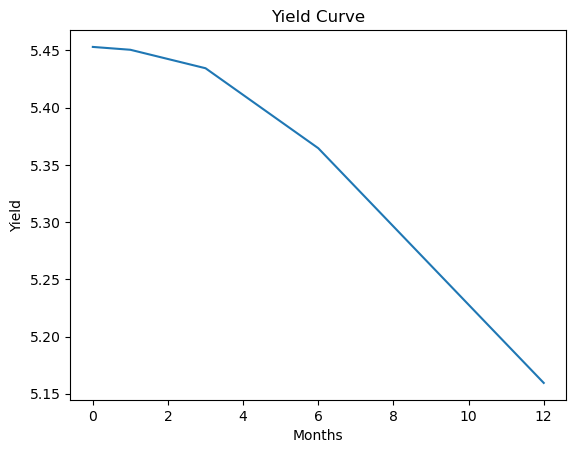

In [6]:
arr = np.array(list(store_rate(test,ref_date).values()))*100
plt.plot([0,1,3,6,12],arr)
plt.ylabel('Yield')
plt.xlabel('Months')
plt.title('Yield Curve')

### 4. Forward rates

- If we are using annual compounding, the forward rate formula is as below:

$f_{t_1, t_2} = \left( \frac{(1 + y_{t_2})^{t_2}}{(1 + y_{t_1})^{t_1}} \right)^{\frac{1}{t_2 - t_1}} - 1$
where $y_{t_1}$ and $y_{t_2}$ are the annaully compounded zero rates at $t_1$ and $t_2$ respectively.

- We shall calculate the discrete forward rates based on the maturities and their respective rates


In [7]:
def forward_rate(t1,t2,y1,y2,DIY=360):
    """ACT/360"""
    t1 /= DIY
    t2 /= DIY
    return ((1 + y2)**t2 / (1 + y1)**t1)**(1 / (t2 - t1)) - 1

In [8]:
store_dict = store_rate(test,ref_date)

In [9]:
store_dict

{1: 0.0545309640693703,
 34: 0.05450604731660929,
 92: 0.05434461648668871,
 182: 0.05364586368225502,
 363: 0.05159480667466937}

In [10]:
mat_in_days = [k for k,v in store_dict.items()]
rates = [v for k,v in store_dict.items()]

In [11]:
discrete_rates = dict()
DIY = 360
for i in range(len(store_dict)-1):
    t1, t2 = mat_in_days[i], mat_in_days[i+1]
    y1, y2 = rates[i], rates[i+1]    
    f = forward_rate(t1,t2,y1,y2,DIY=360)
    discrete_rates[f'From {round(t1/DIY,3)} years to {round(t2/360,3)} years'] = f 
    

In [12]:
discrete_rates

{'From 0.003 years to 0.094 years': 0.054505292272685635,
 'From 0.094 years to 0.256 years': 0.054249996110708576,
 'From 0.256 years to 0.506 years': 0.05293206167510167,
 'From 0.506 years to 1.008 years': 0.04953644364104459}

In [13]:
#testing
#{1: 0.0545309640693703,
# 34: 0.05450604731660929,}

inter_test = interpolate.interp1d([1,34], [0.0545309640693703,0.05450604731660929], kind='linear')
d = 30
inter_test(d)

array(0.05450907)

### 3. Plot the results for 4 different dates
- We will plot the yield curve for 4 different business dates from 31 May 2024 to 5 June 2024.
- Data is obtained from https://www.cmegroup.com/market-data/cme-group-benchmark-administration/term-sofr.html

In [14]:
key = ['1M','3M','6M','12M']

date_1 = dt.datetime(2024,6,5)
spot_1 = 5.33/100
val_1 = [5.32791, 5.33751, 5.28465, 5.11324]

date_2 = dt.datetime(2024,6,4)
spot_2 = 5.33/100
val_2 = [5.32752, 5.33849, 5.29862, 5.15295]

date_3 = dt.datetime(2024,6,3)
spot_3 = 5.35/100
val_3 = [5.32794, 5.33995, 5.30726, 5.18353]

date_4 = dt.datetime(2024,5,31)
spot_4 = 5.34/100
val_4 = [5.32981, 5.34284, 5.31419, 5.20197]

dl = [date_1, date_2, date_3, date_4]
sl = [spot_1, spot_2, spot_3, spot_4]
vl = [val_1, val_2, val_3, val_4]

[]

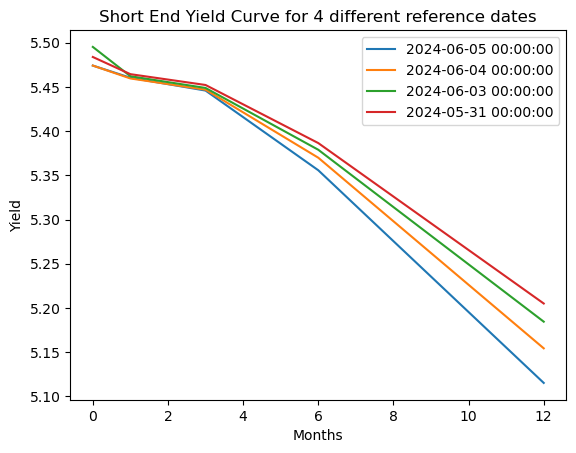

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

for i in range(4):
    df = create_df(dl[i], sl[i], dict(zip(key,np.array(vl[i])/100)))
    arr = np.array(list(store_rate(df,dl[i]).values()))*100
    plt.plot([0,1,3,6,12],arr,label = dl[i])

plt.title('Short End Yield Curve for 4 different reference dates')
plt.ylabel('Yield')
plt.xlabel('Months')
plt.legend()    
plt.plot()

### 5. Observations & Improvements:
- Regarding the discrete forwards, the forward rates are positive. This helps to avoid arbitrage.
- We observe that there has almost a parallel shift in the yield curve down from 31 May to 5 June. One explaination for this is that forward rates are expected to go down based on market sentiments. This would imply that market participants could be expecting a rate cut in the coming days or months.
- Since only the short end of the yield curve has been constructed, the next step would be to extend the yield curve for longer maturities. This can be done using SOFR swaps that have maturities ranging from 1 year to 30 year. However, such construction would be much more complicated than Term SOFRs.